In [1096]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

np.random.seed(2018)

C:\Users\sanfe\AppData\Local\Temp\ipykernel_12300\787212928.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


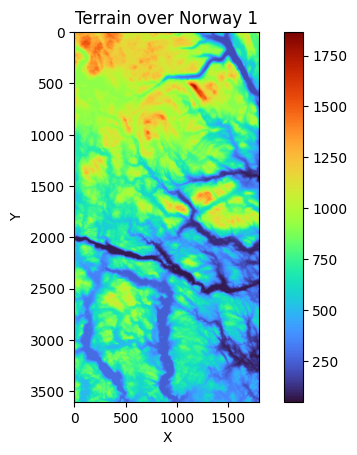

In [1097]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap = "turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.savefig("Terrain_data.png")
plt.show()

In [1098]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

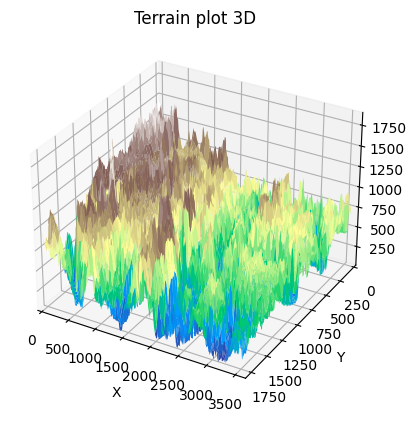

In [1099]:
# Represent the entire dataset in a 3D plot, with colors according to the height of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T, y.T, terrain1, cmap = "terrain")
ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)
plt.title("Terrain plot 3D")
plt.savefig("Terrain_plot_3D.png")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [1100]:
#create design matrix (credits: M. Hjorth-Jensen: Weekly Material, Week 35)
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Define a function for Mean Square Error
def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n

# Define a function for R2
def rsquare(y, ypredict):
	ypredict = ypredict.reshape(-1,1)
	return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))

# Define a function which applies min-mas scaling
def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

In order to avoid the complications related to the problem of dealing with a high number of data, we considered it useful to reduce the number of points to take into consideration in the analysis by selecting randomly 1500 points from the available data. Afterwards, both the inputs and the output have been scaled using min-max scaling. We decided to apply min-max scaling in order to transform all of our data into values between 0 and 1. In this way, all the data that we have can be compared without problems of any kind.

In [1101]:
# Select at random 1500 points from the entire set of points (beacsue there are too many points and otherwise the models will be very slow)
num_points = 1500
points = np.zeros([num_points, 2])
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size = 1500), np.random.randint(0, terrain1.shape[1], size = 1500)))

# The z vector contains only the values relative to the 1500 randomly selected point
z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i,0])][int(points[i,1])]

# Scale the data
z = min_max_scaling(z)
points = np.column_stack((min_max_scaling(points[:,0]), min_max_scaling(points[:,1])))

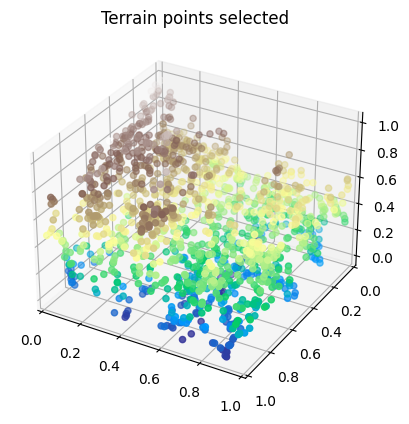

In [1102]:
# Represent the selected points into a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, y = np.meshgrid(range(3601), range(1801))
ax.scatter(points[:,0], points[:,1], z, cmap = "terrain", c = z) # Create a scatterplot with colors according to the height of the point
plt.title("Terrain points selected")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.savefig("Terrain_points_selected.png")
plt.show()

**OLS**

In [1103]:
maxdegree = 20

# Create the design matrix
X = create_X(points[:, 0], points[:, 1], maxdegree)

# Removing the intercept column
X = X[:, 1:]

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

In [1104]:
MSE_train = np.zeros(maxdegree)
MSE_test = np.zeros(maxdegree)
rsqr_train = np.zeros(maxdegree)
rsqr_test = np.zeros(maxdegree)

for i in range(1, maxdegree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = x_train[:,0:c-1]

        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train
		 
        ypredict = X_tilde @ beta
        ypredict_test = x_test[:,0:c-1] @ beta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)
        rsqr_train[i-1]= rsquare(z_train, ypredict)
        rsqr_test[i-1]= rsquare(z_test, ypredict_test)

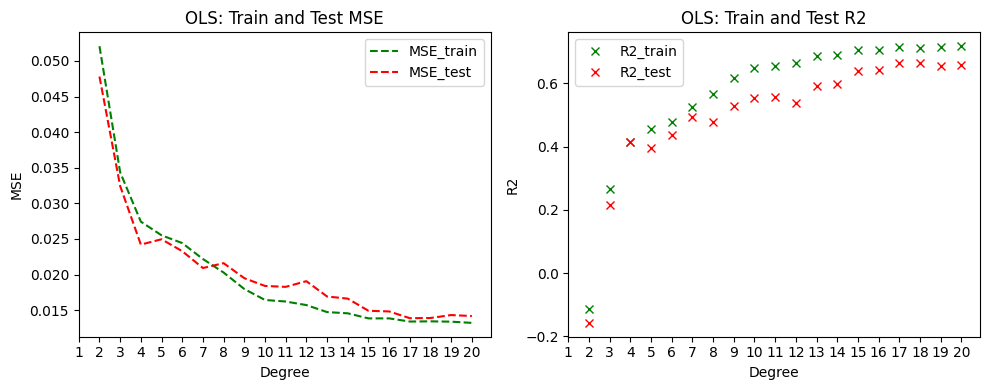

In [1105]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 0.0001
axs[0].plot(range(2,maxdegree+1),MSE_train[1:], 'g--', label = 'MSE_train')
axs[0].plot(range(2,maxdegree+1),MSE_test[1:], 'r--', label = 'MSE_test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('OLS: Train and Test MSE')
axs[0].legend()

# Plot for lambda = 572236.765935022
axs[1].plot(range(2,maxdegree+1),rsqr_train[1:], 'gx', label = 'R2_train')
axs[1].plot(range(2,maxdegree+1),rsqr_test[1:], 'rx', label = 'R2_test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('R2')
axs[1].set_title('OLS: Train and Test R2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
#plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

The above figure represents the Mean Square Error (dashed lines) and the coefficient $R^2$ (crosses) for both the train and the test samples, after the application of the Ordinary Least Square method for different polynomial degrees. The values for train and test for both MSE and $R^2$ seems very similar, with - as expected - a slight better behaviour for the training sample (with a bit smaller MSE and higher $R^2$). From the graph, it is clear that the MSEs decrease as the complexity of the model increases (i.e. as the polynomial degree increases). If the improvement of the MSE values is better in the first degrees, then, form degree 6 or 7, the error seems to be more or less stable, even with a very low worsening around degree 13/14. The same trend is observable for the coefficient $R^2$, obviously with an opposite behavior: instead of increasing with complexity, it decreases. This makes sense, since the $R^2$ measures how well future samples are likely to be predicted by the model.

In [1106]:
max_deg = 20

train_r2 = np.zeros(max_deg)
train_mse = np.zeros(max_deg)
test_r2 = np.zeros(max_deg)
test_mse = np.zeros(max_deg)

for deg in range(1, max_deg):
        c = int((deg+2)*(deg+1)/2)
        X_tilde = x_train[:,0:c-1]
        model = LinearRegression(fit_intercept = True)
        model.fit(X_tilde, z_train)

        z_tilde = model.predict(X_tilde)
        z_predict = model.predict(x_test[:,0:c-1])

        train_mse[deg] = (MSE(z_train, z_tilde))
        test_mse[deg] = (MSE(z_test, z_predict))
        rsqr_train[deg]= rsquare(z_train, z_tilde)
        rsqr_test[i-deg]= rsquare(z_test, z_predict)

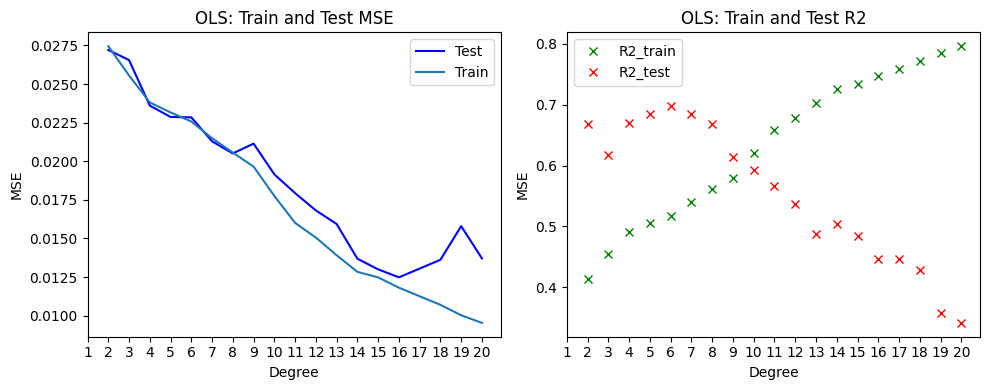

In [1107]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 0.0001
axs[0].plot(range(2,max_deg+1),test_mse[1:],color='b',label="Test")
axs[0].plot(range(2,max_deg+1),train_mse[1:],label="Train")
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('OLS: Train and Test MSE')
axs[0].legend()

# Plot for lambda = 572236.765935022
axs[1].plot(range(2,max_deg+1),rsqr_train[1:], 'gx', label = 'R2_train')
axs[1].plot(range(2,max_deg+1),rsqr_test[1:], 'rx', label = 'R2_test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('OLS: Train and Test R2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
#plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

We can observe that the test error is higher than the train error for higher complexities. The positive aspect is that, up to degree 16, both train and test error have a decreasing trend, thus confirming that complexity reduces the MSEs. From degree 17, while the train error keeps getting better and better, the test error start to become worse than before. This is due to the phenomenon of overfitting: since the model with high complexity is constructed to perform very well with the test data, when it deals with a new sample of points (the test sample), its performance accuracy is reduced. 

On the contrary, looking at the $R^2$ plot, the values for the train set are worse than the ones of the test set for degrees lower than or equal to 9. Then, from degree 10, the train coefficient start to increase in a very good trend, but at the same time the test coefficient starts decreasing very quickly (reaching low values, even under 0.4). Thus, the phenomenon of overfitting is verified again. 

In [1108]:
MSE_test_OLS = MSE_test
MSE_test_OLS

array([0.09690563, 0.04780261, 0.03243146, 0.02420863, 0.02495393,
       0.02328209, 0.02091398, 0.02159768, 0.01948913, 0.0183985 ,
       0.01827091, 0.0190686 , 0.0169188 , 0.01661666, 0.01491318,
       0.01481878, 0.01387048, 0.01389601, 0.01431077, 0.01417046])

In [1109]:
print("The minimum value of MSE for OLS is registered with a polynomial degree of:")
print(np.argmin(MSE_test_OLS))

The minimum value of MSE for OLS is registered with a polynomial degree of:
16


The minimum value of the MSE for the test sample is obtained with a polynomial degree of 16. With this degree, also the train MSE is low. As a consequence, a goot choice is to apply OLS with degree 16. 

**Ridge**

The second step consists in applying Ridge Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [1142]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

MSE_train_Ridge = np.zeros((nlambdas, maxdegree))
MSE_test_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_train_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_test_Ridge = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(2, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:,0:c-1]

            Ridge = linear_model.Ridge(lambdas[j], max_iter = 1000)
            Ridge.fit(X_tilde, z_train)
            z_tilde = Ridge.predict(X_tilde)
            z_predict = Ridge.predict(x_test[:,0:c-1])

            # Store the values of MSE and R2
            MSE_train_Ridge[j, i-1] = MSE(z_train, z_tilde)
            MSE_test_Ridge[j, i-1] = MSE(z_test, z_predict)

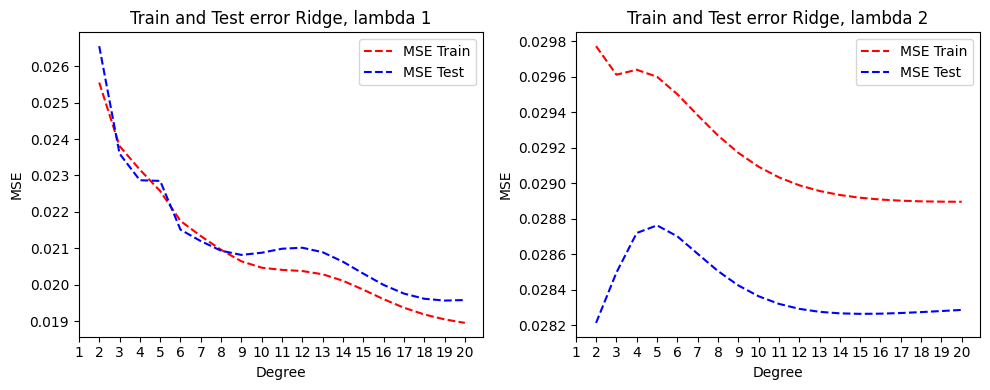

In [1143]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 0.0001
axs[0].plot(range(2, maxdegree + 1), MSE_train_Ridge[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), MSE_test_Ridge[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Ridge, lambda 1')
axs[0].legend()

# Plot for lambda = 572236.765935022
axs[1].plot(range(2, maxdegree + 1), MSE_train_Ridge[69][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), MSE_test_Ridge[69][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Ridge, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

In [1112]:
MSE_test_Ridge

array([[0.        , 0.02655139, 0.0236011 , ..., 0.02083733, 0.02065122,
        0.02049175],
       [0.        , 0.02655139, 0.02360126, ..., 0.02100882, 0.02084081,
        0.02068575],
       [0.        , 0.02655137, 0.02360149, ..., 0.02115822, 0.0210124 ,
        0.02086884],
       ...,
       [0.        , 0.04132663, 0.04132663, ..., 0.04132662, 0.04132662,
        0.04132662],
       [0.        , 0.04132663, 0.04132663, ..., 0.04132663, 0.04132663,
        0.04132663],
       [0.        , 0.04132663, 0.04132663, ..., 0.04132663, 0.04132663,
        0.04132663]])

In [1147]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

MSE_train_Ridge = np.zeros((nlambdas, maxdegree))
MSE_test_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_train_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_test_Ridge = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(2, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:,0:c-1]
            beta = np.linalg.pinv(X_tilde.T @ X_tilde + lambdas[j]*np.ones((len(X_tilde.T),len(X_tilde.T)))) @ X_tilde.T @ z_train
            
            ypredict = X_tilde @ beta
            ypredict_test = x_test[:,0:c-1] @ beta

            # Store the values of MSE and R2
            MSE_train_Ridge[j, i-1] = MSE(z_train, ypredict)
            MSE_test_Ridge[j, i-1] = MSE(z_test, ypredict_test)
            rsqr_train_Ridge[j, i-1]= rsquare(z_train, ypredict)
            rsqr_test_Ridge[j, i-1]= rsquare(z_test, ypredict_test)

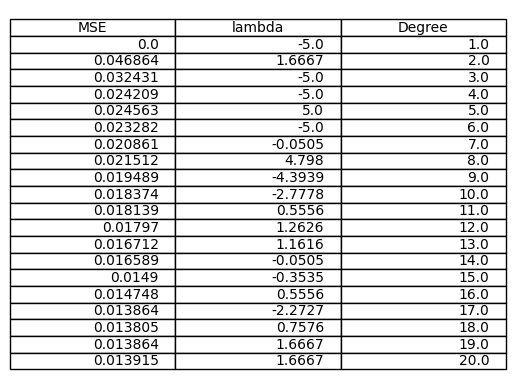

In [1148]:
MSE_Ridge_df = pd.DataFrame(MSE_test_Ridge, index = lambdas, columns = range(1, maxdegree+1))
MSE_Ridge_df = MSE_Ridge_df.T

# Create new columns "MSE" and "lambda" containing the minimum value for each row and the lambda value respectively
MSE_Ridge_df[["MSE", "lambda"]] = MSE_Ridge_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis=1)

# Drop the original columns to keep only "min_value" and "min_column"
MSE_Ridge_df.drop(MSE_Ridge_df.columns.difference(["MSE", "lambda"]), axis=1, inplace=True)

MSE_Ridge_df["Degree"] = MSE_Ridge_df.index

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Ridge_df.values, colLabels = MSE_Ridge_df.columns, loc = 'center')
plt.savefig("Ridge_table.png")
plt.show()

The above table shows the values of $log_{10}(\lambda)$ that minimize the test MSE for each polynomial degree, together with the correspondent MSE value. We can show the plots for some values of lambda. Even in this case, as for OLS, when the model complexity increases, the MSE tends to decrease. The optimal values of MSE are obtained with differnt values of $\lambda$, meaning that for each degree we have a different $\lambda$ which allows to minimize the MSE.

In [1149]:
print("Lambda 1:", lambdas[0])
print("Lambda 2:", lambdas[69])

Lambda 1: 1e-05
Lambda 2: 93.26033468832199


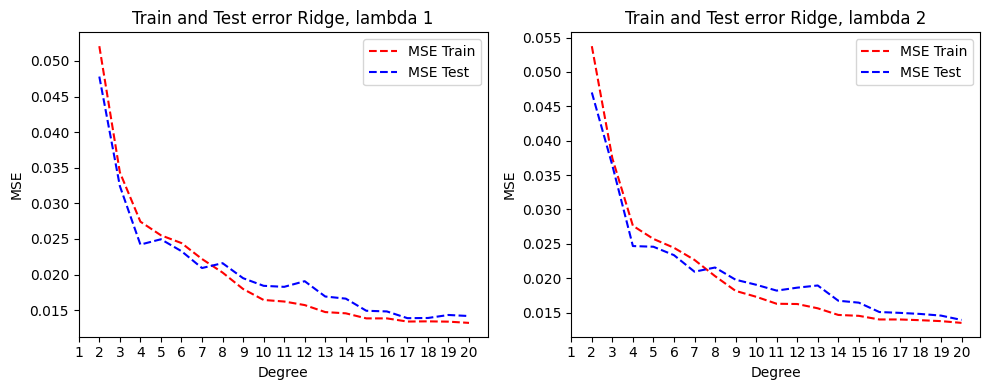

In [1150]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 0.0001
axs[0].plot(range(2, maxdegree + 1), MSE_train_Ridge[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), MSE_test_Ridge[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Ridge, lambda 1')
axs[0].legend()

# Plot for lambda = 572236.765935022
axs[1].plot(range(2, maxdegree + 1), MSE_train_Ridge[69][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), MSE_test_Ridge[69][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Ridge, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

The graphs represent the MSE of the Ridge regression applied with different values of $\lambda$, according to the polynomial degree. The figure on the left in computed with the first value of $\lambda$, i.e. $\lambda = 0.0001$, while the second one corresponds to an intermediate value: $\lambda = 572236.765935022$, which correspond to the $70^{th}$ value of the tested lambdas. Looking at the two graphs together, it can be immediately noticed that their shape is very similar: they both start with high levels of MSE for low polynomial degrees, and then the error decreases. The main difference between the two cases is that with the first value of $\lambda$, the MSE is always lower than for the second case, which means that the first model is better. Moreover, in the second plot, it seems that a low MSE is reached with a degree equal to 4, but after that the results are more or less stable: in this case, adding additional complexity to the model does not give any contribution. The same happens also in the first case, but not as much as in the second one.

**Lasso**

The next step consists in applying Lasso Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [1137]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

MSE_train_Lasso = np.zeros((nlambdas, maxdegree))
MSE_test_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_train_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_test_Lasso = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:, 0:c-1]
            
            RegLasso = linear_model.Lasso(lambdas[j], max_iter = 500)
            RegLasso.fit(X_tilde, z_train)

            ypredict_Lasso = RegLasso.predict(X_tilde)
            ypredict_test_Lasso = RegLasso.predict(x_test[:, 0:c-1])

            # Store the values of MSE and R2
            MSE_train_Lasso[j, i-1] = MSE(z_train, ypredict_Lasso)
            MSE_test_Lasso[j, i-1] = MSE(z_test, ypredict_test_Lasso)
            rsqr_train_Lasso[j, i-1] = rsquare(z_train, ypredict_Lasso)
            rsqr_test_Lasso[j, i-1] = rsquare(z_test, ypredict_test_Lasso)

c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+01, tolerance: 5.615e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.466e+00, tolerance: 5.615e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

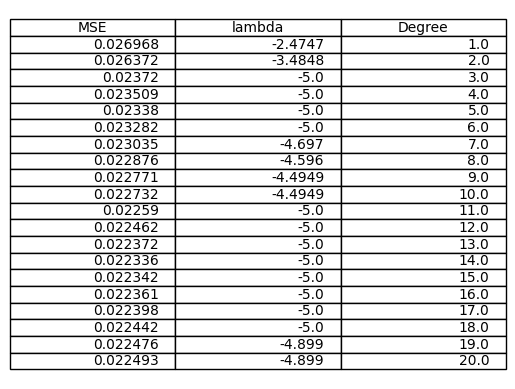

In [1138]:
MSE_Lasso_df = pd.DataFrame(MSE_test_Lasso, index = lambdas, columns = range(1, maxdegree + 1))
MSE_Lasso_df = MSE_Lasso_df.T

# Create a new column "MSE" containing the minimum value for each row
MSE_Lasso_df[["MSE", "lambda"]] = MSE_Lasso_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis = 1)

# Drop the original columns to keep only "min_value" and "min_column"
MSE_Lasso_df.drop(MSE_Lasso_df.columns.difference(["MSE", "lambda"]), axis = 1, inplace = True)

MSE_Lasso_df["Degree"] = MSE_Ridge_df.index

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Lasso_df.values, colLabels = MSE_Lasso_df.columns, loc = 'center')
plt.savefig("Ridge_table.png")
plt.show()

As for Ridge Regression, for Lasso Regression we created a table to compare the values of lambda minimizing the MSE for each polynomial degree. As we can see from the figure, the majority of the best values of MSE are given by the same value of $\lambda$: $\lambda = 0.0001$. In general, we can notice that the MSE is larger than in the previous case, meaning that Lasso is not working very good with our data.

In [1139]:
print("Lambda 1:", lambdas[0])
print("Lambda 2:", lambdas[69])

Lambda 1: 1e-05
Lambda 2: 93.26033468832199


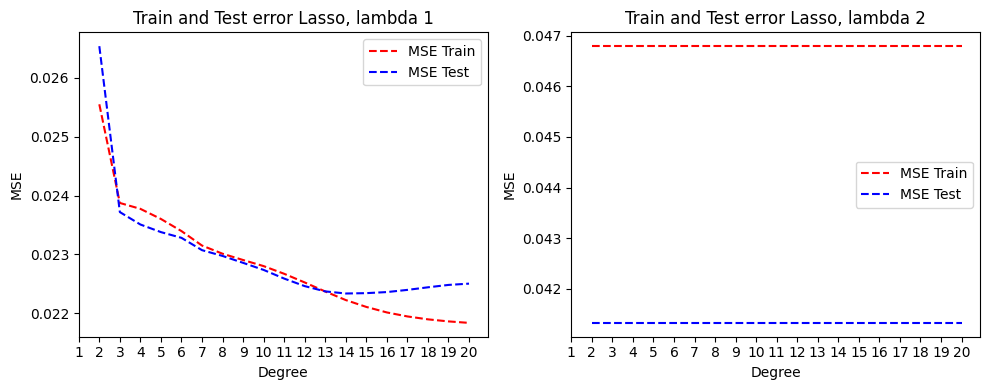

In [1140]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4)) 

# Plot for lambda = 1e-05
axs[0].plot(range(2, maxdegree + 1), MSE_train_Lasso[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), MSE_test_Lasso[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Lasso, lambda 1')
axs[0].legend()

# Plot for lambda = 93.26033468832199
axs[1].plot(range(2, maxdegree + 1), MSE_train_Lasso[69][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), MSE_test_Lasso[69][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Lasso, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

**Comparison**

Finally, we can make a comparison between the three methods. We decided to evaluate their performance with a polynomial degree equal to 16 (which was the optimal value in OLS). 

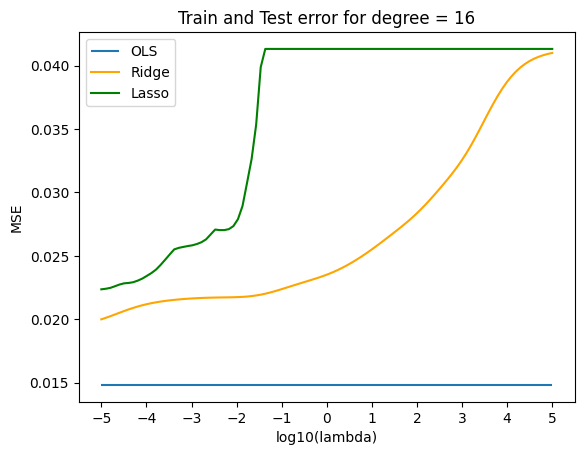

In [1146]:
degree = 16

plt.figure()
plt.hlines(MSE_test_OLS[15], -5, 5, label = 'OLS')
plt.plot(np.log10(lambdas), MSE_test_Ridge[:, 15], 'orange', label = 'Ridge')
plt.plot(np.log10(lambdas), MSE_test_Lasso[:, 15], 'green', label = 'Lasso')
plt.xlabel('log10(lambda)')
plt.xticks(ticks = range(-5,6))
plt.ylabel('MSE')
plt.title('Train and Test error for degree = 16')
plt.legend()
plt.savefig("Train and Test error for degree = 16.png")
plt.show()

Cross-validation

In [1070]:
# Initialize a KFold instance for k = 5
k = 5
kfold = KFold(n_splits = k)
z_train = z_train.ravel() 

estimated_mse_sklearn_5 = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = linear_model.Ridge(alpha = lmb)
    estimated_mse_folds = cross_val_score(ridge, x_train, z_train[:, np.newaxis], scoring = 'neg_mean_squared_error', cv = kfold)
    estimated_mse_sklearn_5[i] = np.mean(-estimated_mse_folds)

    i += 1

In [1093]:
# Initialize a KFold instance for k = 10
k = 10
kfold = KFold(n_splits = k)
z_train = z_train.ravel() 

estimated_mse_sklearn_10 = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = linear_model.Ridge(alpha = lmb)
    estimated_mse_folds = cross_val_score(ridge, x_train, z_train[:, np.newaxis], scoring = 'neg_mean_squared_error', cv = kfold)
    estimated_mse_sklearn_10[i] = np.mean(-estimated_mse_folds)

    i += 1

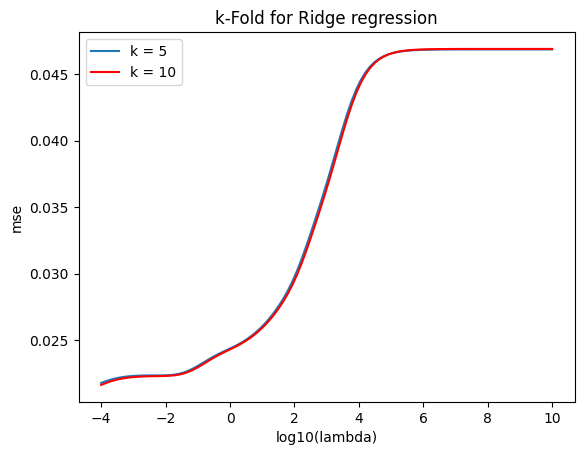

In [1094]:
## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn_5, label = 'k = 5')
plt.plot(np.log10(lambdas), estimated_mse_sklearn_10, color = "r", label = 'k = 10')
plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()
plt.title("k-Fold for Ridge regression")
plt.show()

Bias-Variance tradeoff

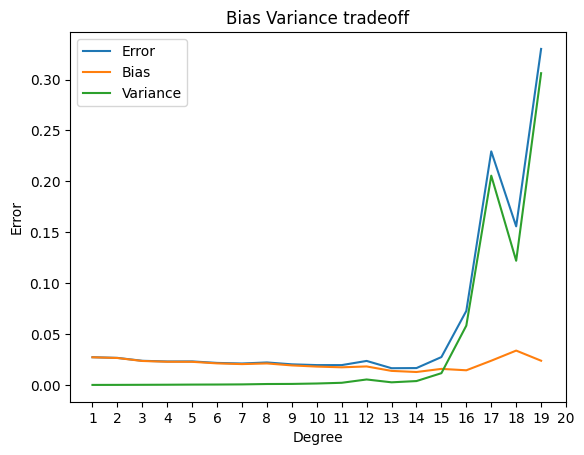

In [1082]:
n_boostraps = 100
z_pred = np.empty((len(z_test), n_boostraps))

maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    model = LinearRegression(fit_intercept = True)
    y_pred = np.empty((z_test.shape[0], n_boostraps))
    c = int((degree+2)*(degree+1)/2)
    X_tilde = x_train[:, 0:c-1]
    for i in range(n_boostraps):
        x_, y_ = resample(X_tilde, z_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test[:, 0:c-1]).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_test - y_pred)**2, axis = 1, keepdims = True) )
    bias[degree] = np.mean( (z_test - np.mean(y_pred, axis = 1, keepdims = True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis = 1, keepdims = True) )

plt.plot(polydegree[1:], error[1:], label='Error')
plt.plot(polydegree[1:], bias[1:], label='Bias')
plt.plot(polydegree[1:], variance[1:], label='Variance')
plt.xticks(ticks = range(1,maxdegree+1))
plt.legend()
plt.xlabel("Degree")
plt.ylabel("Error")
plt.title("Bias Variance tradeoff")
plt.savefig("Bias_Variance_tradeoff")
plt.show()

The phenomenon of overfitting can be further analyzed by studying the decomposition of the MSE into Bias and Variance. The above figure shows exactly what we want to depict: the so-called Bias-Variance tradeoff. The idea is that, as the complexity of the model increases (i.e as the polynomial degree increases), the variance of the model, starting from very low values, starts increasing sharply. This worsening in variance, particularly visible for the highest degrees, is due again to the overfitting problem. While the Bias is more or less stable, the variance is largely affected by a too close adaption of the model to the training set. As a consequence, even small changes in the data will bring significant changes to the model.

Unfortunately, not as expected, the bias in not affected by the polynomial degree: it remains more or less the same for all degrees.  